In [1]:
import numpy as np
import pandas as pd
import os
import requests
import matplotlib.pyplot as plt

import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error

In [2]:
# Set up folder with data:
os.chdir('D:\\01_PROJECTS_sripts_code\\Electricty_Demand\\02_FORECAST')

In [3]:
#%% Function to extract code from GitHub:
def GetGitHubCode(GitUrl):

    response = requests.get(GitUrl) #get data from json file located at specified URL 

    if response.status_code == requests.codes.ok:
        contentOfUrl = response.content
        exec(contentOfUrl, globals() )
    else:
        print('Content was not found.')

In [4]:
# Download functions from GitHub:
GitUrl__Prepare_Data_For_Regression = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Prepare_Data_For_Regression.py'
GetGitHubCode(GitUrl__Prepare_Data_For_Regression)

GitUrl__Make_TS_Regression = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Make_TS_Regression.py'
GetGitHubCode(GitUrl__Make_TS_Regression)

GitUrl__Goodness_Of_Fit = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Goodness_Of_Fit.py'
GetGitHubCode(GitUrl__Goodness_Of_Fit)

GitUrl__Multicollinearity_Check_Functions= 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Multicollinearity_Check_Functions.py'
GetGitHubCode(GitUrl__Multicollinearity_Check_Functions)

GitUrl__Feature_Selection = 'https://raw.githubusercontent.com/kamilbanas85/Phyton_usefull_functions/main/Feature_Selection.py'
GetGitHubCode(GitUrl__Feature_Selection)

In [5]:
# Read Analysis Data:
AnalysisData = pd.read_csv('AnalysisDF.csv',
                           parse_dates =['Date'],
                           index_col = 'Date')

AnalysisData.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 63552 entries, 2015-07-01 01:00:00 to 2022-09-30 00:00:00
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Demand               63552 non-null  float64
 1   air_temperature      63552 non-null  float64
 2   humidity             63552 non-null  float64
 3   sky_cover            63552 non-null  float64
 4   wind_speed           63552 non-null  float64
 5   Population           63552 non-null  float64
 6   RealGDP              63552 non-null  float64
 7   DallasFedManufIndex  63552 non-null  float64
 8   WorkDay              63552 non-null  int64  
 9   hour                 63552 non-null  int64  
 10  day                  63552 non-null  int64  
 11  week                 63552 non-null  int64  
 12  month                63552 non-null  int64  
 13  HDD                  63552 non-null  int64  
 14  CDD                  63552 non-null  int64  
dtypes

In [6]:
##########################################################
##########################################################
#%% Prepare data
##########################################################
##########################################################

In [7]:
# Select Main Data
Dependent_Var = 'Demand'

Independent_Vars = ['HDD',
                    'CDD',
                    'wind_speed',
                    'humidity',
                    'sky_cover',
#                   'Population',
                    'RealGDP',
                    'DallasFedManufIndex',
                    'WorkDay',
                    'hour',
#                   'day',
                    'week'
#                   'month'
                   ]

DummyForColumn = ['hour','week']
LagList = None

In [8]:
# Add Lags
LagWindow = 48
LagsRengeList ={'Demand':48,
                'HDD':LagWindow,
                'CDD':LagWindow,
                'wind_speed':LagWindow,
                'humidity':LagWindow,
                'sky_cover':LagWindow,  
                }


LagList = MakeLagedVariableNames(LagsRangeList= LagsRengeList,\
                                 LagsDirectList = None)

AnalysisData = PrepareLags(AnalysisData, LagList)
Independent_Vars.extend( LagList.keys() )

<string>:234: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


In [9]:
### Cut data to pre-Covid time and crate 2 datasets to show diffrence between a summer and winter predictions

In [11]:
###################
#%% '01' model on summer time
###################

In [12]:
AnalysisData_01 = AnalysisData.loc[:'2019-07']

In [13]:
TestSetDate_01 = '2019-02'

In [14]:
# Prepare Data For Linear Regression
X_01, y_01 =  DevideOnXandY_CreateDummies(AnalysisData_01, 
                                          DependentVar = Dependent_Var,
                                          IndependentVar = Independent_Vars,
                                          DummyForCol = DummyForColumn,
                                          drop_first = True)

X_Train_01, y_Train_01,\
X_Test_01, y_Test_01 =\
            PrepareDataForRegression(X_01, y_01, 
                                     TestSplitInd = TestSetDate_01,
                                     ValSplitInd = None,     
                                     ScalerType = None,
                                     ScalerRange = None,                             
                                     BatchSize = None,
                                     WindowLength = 1)

In [15]:
###################
#%% '02' model on winter time
###################

In [16]:
AnalysisData_02 = AnalysisData.loc[:'2020-02']

In [17]:
TestSetDate_02 = '2019-09'

In [18]:
# Prepare Data For Linear Regression
X_02, y_02 =  DevideOnXandY_CreateDummies(AnalysisData_02, 
                                          DependentVar = Dependent_Var,
                                          IndependentVar = Independent_Vars,
                                          DummyForCol = DummyForColumn)

X_Train_02, y_Train_02,\
X_Test_02, y_Test_02 =\
        PrepareDataForRegression(X_02, y_02, 
                                 TestSplitInd = TestSetDate_02,
                                 ValSplitInd = None,     
                                 ScalerType = None,
                                 ScalerRange = None,                             
                                 BatchSize = None,
                                 WindowLength = 1)

In [19]:
### Selecting Futures - Lags

In [20]:
# backward elimination:
selected_features_BE = BackwardEliminationPvalue(X_Train = X_Train_01, y_Train = y_Train_01)  

In [21]:
# Add based Vriables and Dummies Variables
selected_features_BE__finall = KeepBasicIndeptVarAndDummies(X_Train_01, \
                                                            selected_features_BE,\
                                                            DummyForColumn,\
                                                            KeepBasicIndept = True,\
                                                            KeepDummies = True)

selected_features_BE__finall

['HDD',
 'CDD',
 'wind_speed',
 'humidity',
 'sky_cover',
 'RealGDP',
 'DallasFedManufIndex',
 'WorkDay',
 'Demand_Lag1',
 'Demand_Lag2',
 'Demand_Lag3',
 'Demand_Lag4',
 'Demand_Lag8',
 'Demand_Lag9',
 'Demand_Lag10',
 'Demand_Lag11',
 'Demand_Lag12',
 'Demand_Lag13',
 'Demand_Lag14',
 'Demand_Lag15',
 'Demand_Lag16',
 'Demand_Lag17',
 'Demand_Lag19',
 'Demand_Lag22',
 'Demand_Lag23',
 'Demand_Lag24',
 'Demand_Lag25',
 'Demand_Lag26',
 'Demand_Lag27',
 'Demand_Lag28',
 'Demand_Lag32',
 'Demand_Lag33',
 'Demand_Lag35',
 'Demand_Lag36',
 'Demand_Lag37',
 'Demand_Lag38',
 'Demand_Lag39',
 'Demand_Lag41',
 'Demand_Lag42',
 'Demand_Lag46',
 'Demand_Lag47',
 'Demand_Lag48',
 'HDD_Lag1',
 'HDD_Lag2',
 'HDD_Lag7',
 'HDD_Lag15',
 'HDD_Lag18',
 'HDD_Lag20',
 'HDD_Lag23',
 'HDD_Lag24',
 'HDD_Lag26',
 'HDD_Lag35',
 'HDD_Lag36',
 'HDD_Lag45',
 'HDD_Lag48',
 'CDD_Lag4',
 'CDD_Lag12',
 'CDD_Lag13',
 'CDD_Lag19',
 'CDD_Lag20',
 'CDD_Lag24',
 'CDD_Lag25',
 'CDD_Lag26',
 'CDD_Lag30',
 'CDD_Lag42',
 'wi

In [22]:
# Update X set and LagList
X_Train_01 = X_Train_01.filter(items= selected_features_BE__finall)
X_Test_01 = X_Test_01.filter(items= selected_features_BE__finall)

X_Train_02 = X_Train_02.filter(items= selected_features_BE__finall)
X_Test_02 = X_Test_02.filter(items= selected_features_BE__finall)


LagList = { var : LagNr for var, LagNr in LagList.items() \
                           if var in selected_features_BE__finall }


In [23]:
##########################################################
##########################################################
#%% FIT MODEL - Train Set
##########################################################
##########################################################

In [24]:
###################
#%% '01' model on summer time
###################

In [25]:
AddIntercept = True
ModelLR_01 = sm.OLS( y_Train_01, sm.add_constant(X_Train_01) )

ModelLRFitted_01 = ModelLR_01.fit()

# Check model
ModelLRFitted_01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Demand   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.612e+05
Date:                Thu, 23 Mar 2023   Prob (F-statistic):               0.00
Time:                        00:32:37   Log-Likelihood:            -2.2631e+05
No. Observations:               31415   AIC:                         4.529e+05
Df Residuals:                   31247   BIC:                         4.544e+05
Df Model:                         167                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   3.0970     96.403      0.032      0.974    -185.857     192.051
HDD                    59.5240      2.626     22.669      0.000      54.377      64.671
CDD                    58.0600      1.553     37.380      0.000      55.016      61.104
wind_speed              3.3438      0.660      5.066      0.000       2.050       4.638
humidity               -0.5096      0.541     -0.942      0.346      -1.570       0.550
sky_cover               0.0585      0.079      0.741      0.459      -0.096       0.213
RealGDP                 0.0004   5.79e-05      6.993      0.000       0.000       0.001
DallasFedManufIndex     0.8004      0.142      5.644      0.000       0.522       1.078
WorkDay                99.2582      4.584     21.654      0.000      90.274     108.243
Demand_Lag1             1.9348      0.006    346.255      0.000       1.924       1.946
Demand_Lag2            -1.4512      0.012   -122.927      0.000      -1.474      -1.428
Demand_Lag3             0.6442      0.012     52.917      0.000       0.620       0.668
Demand_Lag4            -0.1925      0.007    -29.519      0.000      -0.205      -0.180
Demand_Lag8            -0.0155      0.006     -2.537      0.011      -0.027      -0.004
Demand_Lag9             0.0646      0.010      6.380      0.000       0.045       0.084
Demand_Lag10            0.0360      0.010      3.596      0.000       0.016       0.056
Demand_Lag11           -0.1133      0.012     -9.241      0.000      -0.137      -0.089
Demand_Lag12            0.0912      0.015      6.268      0.000       0.063       0.120
Demand_Lag13           -0.0766      0.015     -5.070      0.000      -0.106      -0.047
Demand_Lag14            0.0450      0.014      3.107      0.002       0.017       0.073
Demand_Lag15           -0.0479      0.012     -3.908      0.000      -0.072      -0.024
Demand_Lag16            0.0358      0.009      3.844      0.000       0.018       0.054
Demand_Lag17            0.0209      0.006      3.390      0.001       0.009       0.033
Demand_Lag19           -0.0219      0.003     -6.970      0.000      -0.028      -0.016
Demand_Lag22           -0.0452      0.007     -6.755      0.000      -0.058      -0.032
Demand_Lag23            0.0650      0.011      5.717      0.000       0.043       0.087
Demand_Lag24            0.6935      0.011     64.285      0.000       0.672       0.715
Demand_Lag25           -1.3999      0.011   -125.563      0.000      -1.422      -1.378
Demand_Lag26            1.0581      0.013     79.559      0.000       1.032       1.084
Demand_Lag27           -0.4646      0.012    -37.313      0.000      -0.489      -0.440
Demand_Lag28            0.1190      0.007     18.085      0.000       0.106       0.132
Demand_Lag32            0.0144      0.006      2.552      0.011       0.003       0.025
Dem

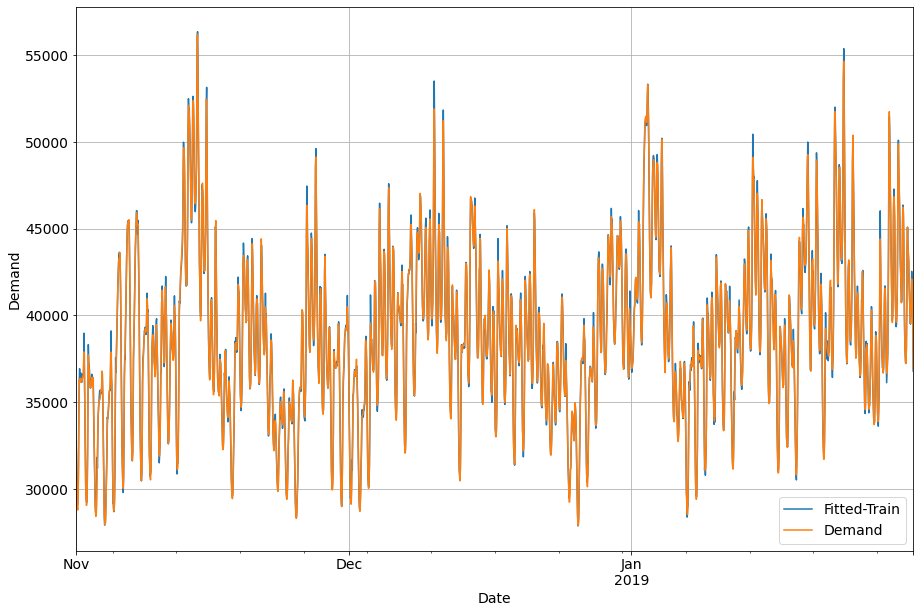

In [32]:
# Plot fitted model
ModelLRFitted_01.fittedvalues.rename('Fitted-Train').to_frame()\
    .join(y_Train_01)\
    .loc['2018-11':'2019-06']\
    .plot()

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [35]:
###################
#%% '02' model on winter time
###################

In [36]:
AddIntercept = True
ModelLR_02 = sm.OLS( y_Train_02, sm.add_constant(X_Train_02) )

ModelLRFitted_02 = ModelLR_02.fit()

In [37]:
##########################################################
##########################################################
#%% Check Model - Test Set
##########################################################
##########################################################

In [29]:
###################
#%% test '01' model on summer time
###################

In [38]:
# Make prediction on test set
yhat_Test_LR_01, X_Test_withLags = \
   MakeTSforecast(X_Test_01, ModelLRFitted_01,\
                  DependentVar = Dependent_Var,
                  Intecept = AddIntercept,
                  LagsList = LagList,
                  Scaler_y = None, Scaler_X = None,
                  Test_or_Forecast = 'Test')

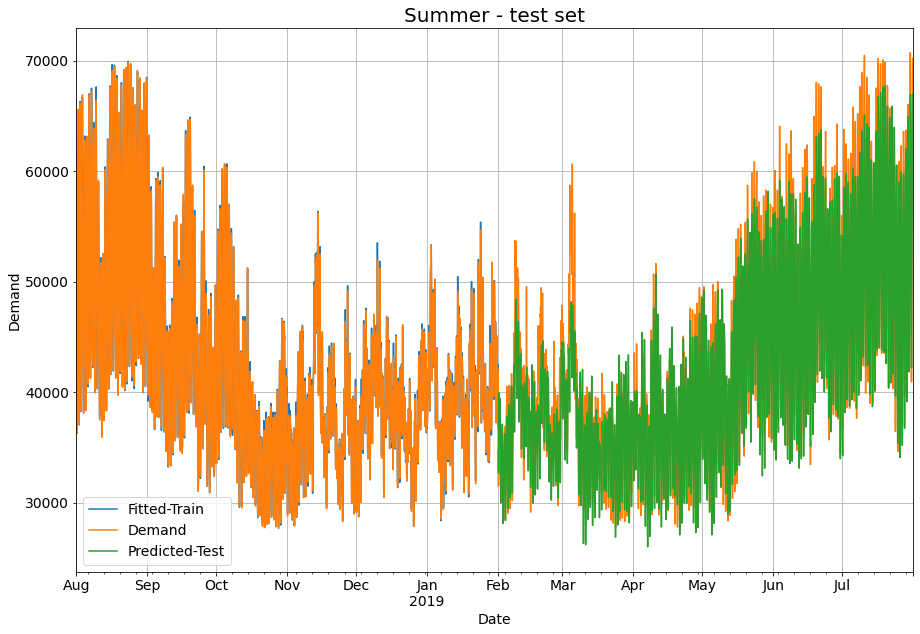

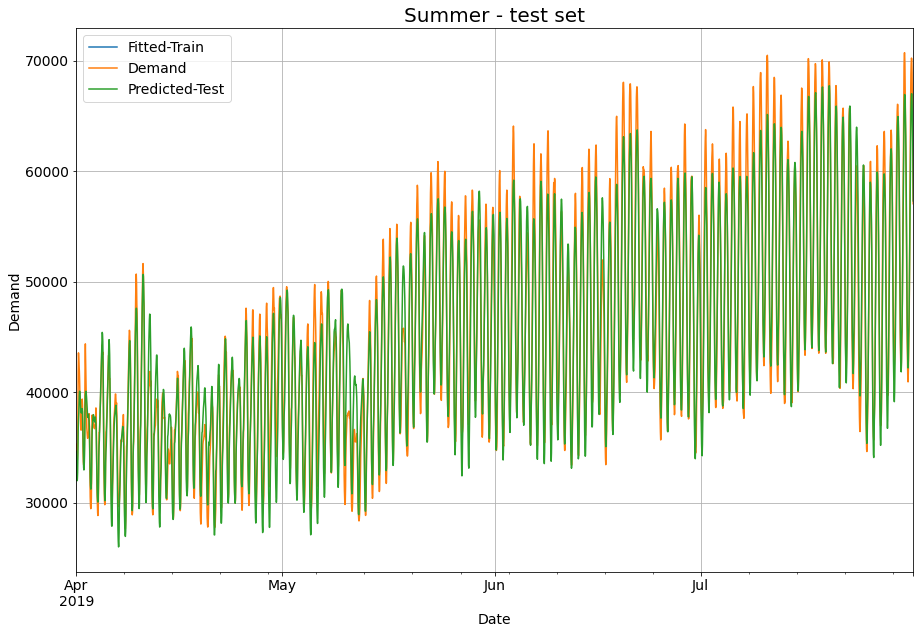

In [39]:
# Plot Fitted Data
ModelLRFitted_01.fittedvalues.rename('Fitted-Train').to_frame()\
        .join(y_Train_01)\
        .append( yhat_Test_LR_01.join(y_Test_01) )\
        .loc['2018-08':]\
        .plot()
        
plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Summer - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()



ModelLRFitted_01.fittedvalues.rename('Fitted-Train').to_frame()\
        .join(y_Train_01)\
        .append( yhat_Test_LR_01.join(y_Test_01) )\
        .loc['2019-04':]\
        .plot()

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Summer - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [40]:
print( CalculateR2andR2adj(y_Test_01, yhat_Test_LR_01, X_Test_01, const = AddIntercept) )
print('')
print( f'MAE:  {round(mean_absolute_error(y_Test_01, yhat_Test_LR_01),2)}'  )
print( f'MAPE: {round(mean_absolute_percentage_error(y_Test_01, yhat_Test_LR_01)*100,2)}' )
print( f'RSME: {round(np.sqrt(mean_squared_error(y_Test_01, yhat_Test_LR_01)),2)}' )

R2: 0.9339
R2_adj: 0.9313
(0.9339, 0.9313)

MAE:  1786.22
MAPE: 4.12
RSME: 2421.63


In [41]:
###################
#%% test '02' model on  winter time
###################

In [42]:
# Make prediction on test set
yhat_Test_LR_02, X_Test_withLags = \
   MakeTSforecast(X_Test_02, ModelLRFitted_02,\
                  DependentVar = Dependent_Var,
                  Intecept = AddIntercept,
                  LagsList = LagList,
                  Scaler_y = None, Scaler_X = None,
                  Test_or_Forecast = 'Test')

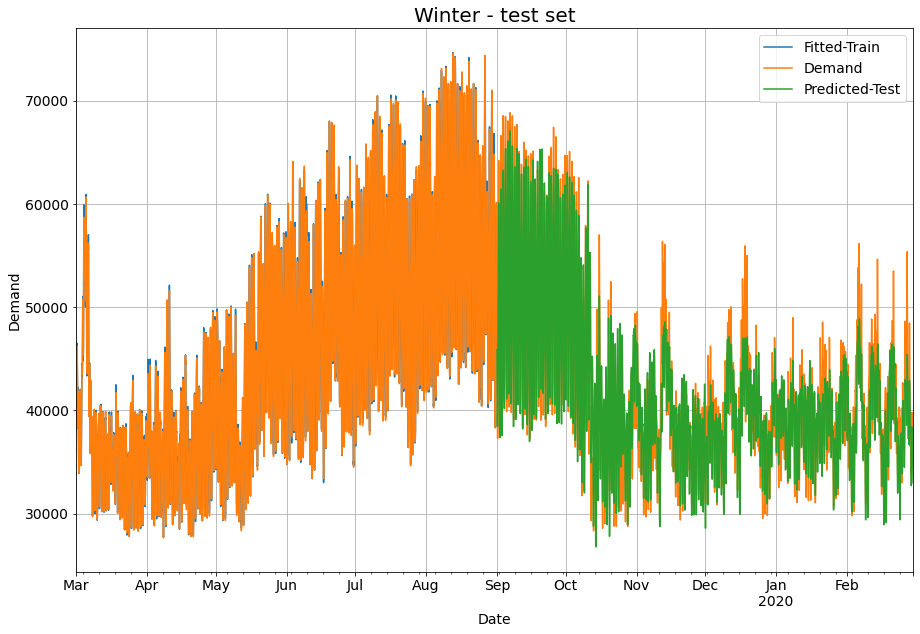

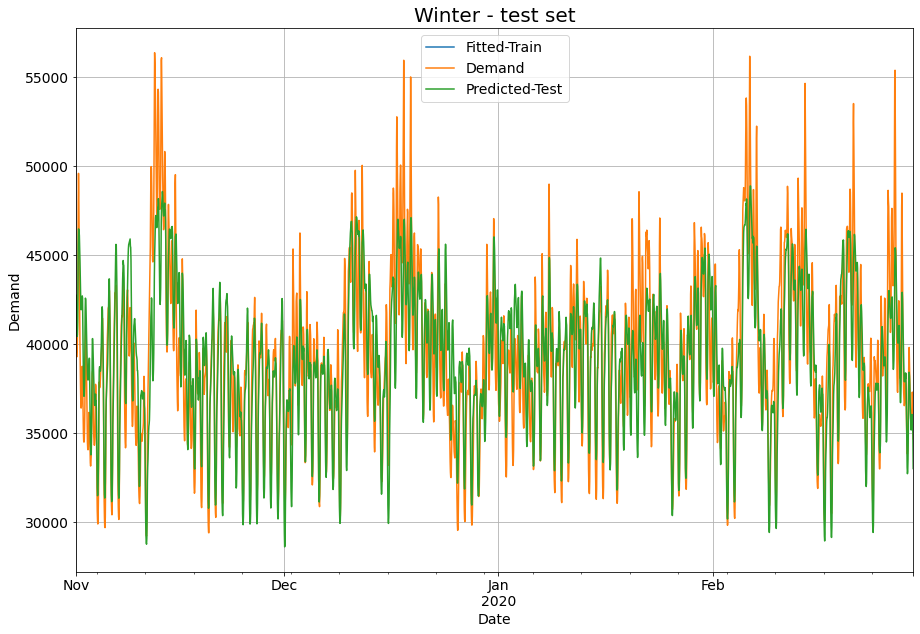

In [43]:
# Plot Fitted Data
ModelLRFitted_02.fittedvalues.rename('Fitted-Train').to_frame()\
        .join(y_Train_02)\
        .append( yhat_Test_LR_02.join(y_Test_02) )\
        .loc['2019-03':]\
        .plot()

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Winter - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()


ModelLRFitted_02.fittedvalues.rename('Fitted-Train').to_frame()\
        .join(y_Train_02)\
        .append( yhat_Test_LR_02.join(y_Test_02) )\
        .loc['2019-11':]\
        .plot()

plt.ylabel('Demand', fontsize=14)
plt.xlabel('Date', fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Winter - test set', fontsize=20)
plt.legend(fontsize=14)
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

In [44]:
print( CalculateR2andR2adj(y_Test_02, yhat_Test_LR_02, X_Test_02, const = AddIntercept) )
print('')
print( f'MAE:  {round(mean_absolute_error(y_Test_02, yhat_Test_LR_02),2)}'  )
print( f'MAPE: {round(mean_absolute_percentage_error(y_Test_02, yhat_Test_LR_02)*100,2)}' )
print( f'RSME: {round(np.sqrt(mean_squared_error(y_Test_02, yhat_Test_LR_02)),2)}' )

R2: 0.8837
R2_adj: 0.8791
(0.8837, 0.8791)

MAE:  1939.08
MAPE: 4.73
RSME: 2660.94


In [45]:
##########################################################
##########################################################
#%% Check Residuals and OLS assumption
##########################################################
##########################################################

In [46]:
###################
#%% Check AutoCorrelation of residuals
###################

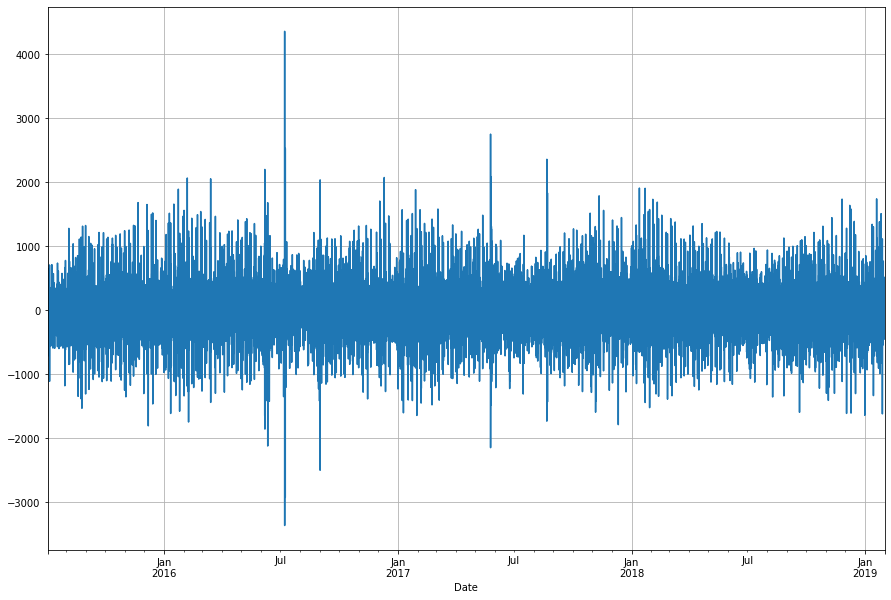

In [47]:
# Plot Resudulas
ModelLRFitted_01.resid.plot()
plt.grid()
plt.rcParams['figure.figsize'] = [15, 10]
plt.show()

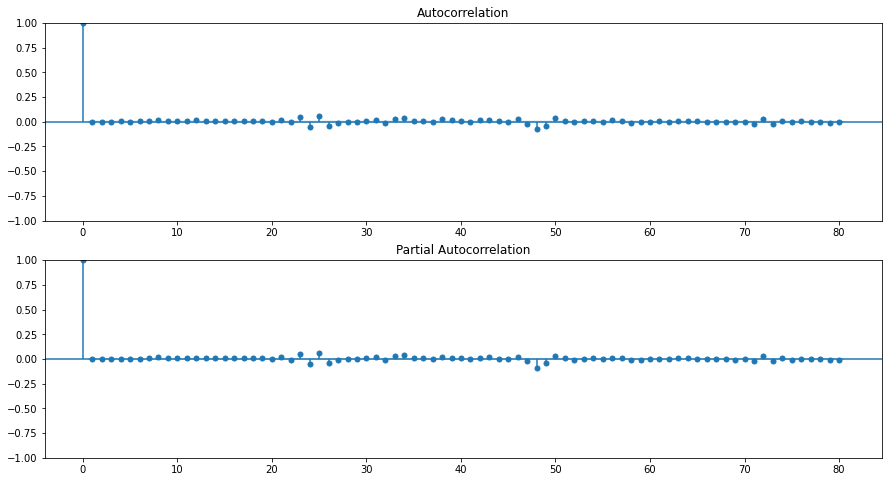

In [48]:
# plot autocorelogram
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, ax = plt.subplots(2,1, figsize=(15,8))
fig = plot_acf(ModelLRFitted_01.resid, lags=80, ax=ax[0])
fig = plot_pacf(ModelLRFitted_01.resid, lags=80, ax=ax[1], method='ywm')
plt.show()

In [49]:
# Durbin-Whatson Test - 1-order autocorrelation
# A value:
#   - 2.0:               no autocorrelation
#   - 0 to less than 2:  positive autocorrelation
#   - from 2 to 4:       negative autocorrelation

In [50]:
from statsmodels.stats.stattools import durbin_watson

durbin_watson(ModelLRFitted_01.resid).round(3)

2.002

In [51]:
# To check higher order autocorrelation: Ljung-box test 
from statsmodels.stats.diagnostic import acorr_ljungbox
acorr_ljungbox(ModelLRFitted_01.resid)
# H0 - a residuals are independently distributed
# p-values greater than 0.05 -> H0 is not receted for a lot of lags

,lb_stat,lb_pvalue
1,0.033330,0.855139
2,0.152260,0.926696
3,0.228237,0.972907
4,0.554261,0.968008
5,0.683492,0.983862
6,1.048711,0.983698
7,4.393909,0.733452
8,16.178902,0.039890
9,20.791982,0.013607
10,21.676349,0.016841


In [52]:
# Based on ACF, PACF plots and on the statistics we can conlude that residuals are autocorrelated, 
# howerver the autocorrelation is not strong. 

In [53]:
###################
#%% Check Heteroskedasticity of residuals
###################

In [54]:
# Breusch-Pagan Lagrange Multiplier test
from statsmodels.compat import lzip
from statsmodels.stats.diagnostic import het_breuschpagan

test = het_breuschpagan(ModelLRFitted_01.resid, ModelLRFitted_01.model.exog)
names = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
lzip(names, test)

# H0: Homoscedasticity is present
# the null hypothesis is rejected if p<0.05, so in this case we reject H0, so Hetercedasity is present

[('Lagrange multiplier statistic', 3127.4499112436392),
 ('p-value', 0.0),
 ('f-value', 20.686493597929047),
 ('f p-value', 0.0)]

In [55]:
# Goldfeld-Quandt test
from statsmodels.stats.diagnostic import het_goldfeldquandt

name = ['F statistic', 'p-value']
test = het_goldfeldquandt(ModelLRFitted_01.resid, ModelLRFitted_01.model.exog)
lzip(name, test)
# H0 for the GQ test is homoskedasticity, in our case is not rejected

[('F statistic', 0.9348780665580603), ('p-value', 0.9999864624152361)]

In [56]:
# 2 tests show that Hetercedasity is problem of resiaduals 

In [57]:
###################
#%% Check Correalation Between Regressors and Residuals
###################

In [58]:
## The null hypothesis is that the two variables are uncorrelated
## so p-value greater than 0.05 support uncorrelation
from scipy.stats import pearsonr

resultsLIST = []
for columnName in X_Train_01.columns:

    CorrRegressVsResidDF_temp =\
        pd.DataFrame([pearsonr( ModelLRFitted_01.resid, X_Train_01.loc[:,columnName] )[1].round(4)],\
                     columns = ["p-value"] )
    CorrRegressVsResidDF_temp.index = [columnName]
    resultsLIST.append(CorrRegressVsResidDF_temp)  

results = pd.concat(resultsLIST)

print(results)

            p-value
HDD             1.0
CDD             1.0
wind_speed      1.0
humidity        1.0
sky_cover       1.0
...             ...
week__49        1.0
week__50        1.0
week__51        1.0
week__52        1.0
week__53        1.0

[167 rows x 1 columns]


In [59]:
print( results['p-value'].unique() )

[1.]


In [60]:
# there is no problem with correalation between regressors and residuals 

In [61]:
###################
#%% Check Normality of residuals
###################

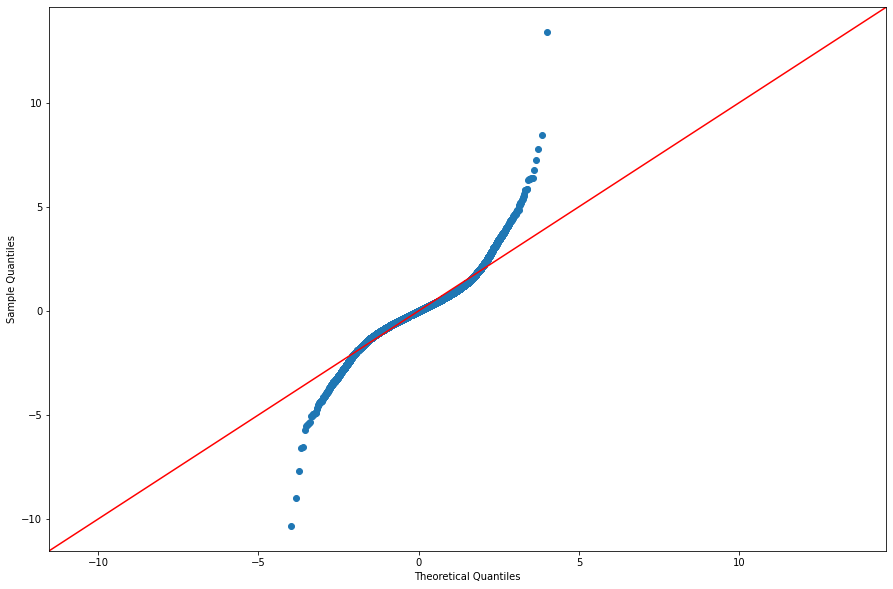

In [62]:
# QQ-Plot of residuals
fig1 = sm.qqplot(ModelLRFitted_01.resid, fit=True, line='45')
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()

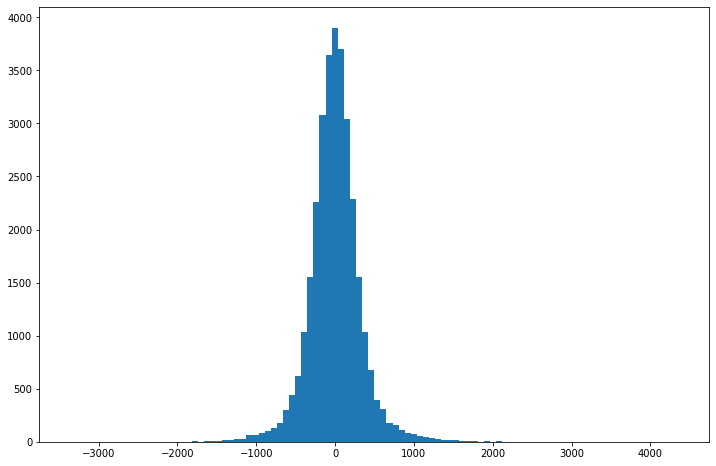

In [63]:
#create a histogram to visualize the distribution
plt.hist(ModelLRFitted_01.resid, 100)
plt.rcParams['figure.figsize'] = [12, 8]
plt.show()

In [64]:
# The is some distortion, however not very big